In [4]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error
from qiskit import Aer, transpile, assemble
import numpy as np
import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import plot_coupling_map
from py_functions.error_cal import error
from py_functions.ent_matrix import Coupling_Circuit
import numpy as np
from itertools import permutations
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [5]:
def noise_simulation(noise : bool, 
                     qc: qiskit.QuantumCircuit, 
                     measure_qubits : list,
                     shots : int, 
                     cmap: list):
    """
        This function simulate the quantum circuit with a certain noise.
        Input:
            noise: bool ; if you want to add a perfect simulation or not.
            qc: QuantumCircuit.
            measure_qubits : list ; the quantum bits to measure.
            shots: int; the number of shots.
            cmap : list; the coupling map of the circuit.
        Output:
            real_dict : dict ; dictionary with the histogram distribution.
    """

    if noise == False:
        ## Perfect simulation
        qc.measure(measure_qubits, measure_qubits)
        Simulation = Aer.get_backend('qasm_simulator')
        Quantum_Transpiler = transpile(qc, Simulation)
        Quantum_Obj = assemble(Quantum_Transpiler, shots=shots)
        real_dict = Simulation.run(Quantum_Obj).result().get_counts()

    else: 
        ## Noise simulation. Taken from the qiskit template.
        T1s = np.random.normal(70e3, 10e3, qc.num_qubits) # Sampled from normal distribution mean 50 microsec
        T2s = np.random.normal(50e3, 10e3, qc.num_qubits)  # Sampled from normal distribution mean 50 microsec

        # Truncate random T2s <= T1s
        T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(qc.num_qubits)])

        # Instruction times (in nanoseconds)
        time_u1 = 0   # virtual gate
        time_u2 = 50  # (single X90 pulse)
        time_u3 = 100 # (two X90 pulses)
        time_cx = 300
        time_reset = 1000  # 1 microsecond
        time_measure = 1000 # 1 microsecond

        # QuantumError objects
        errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                        for t1, t2 in zip(T1s, T2s)]
        errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                        for t1, t2 in zip(T1s, T2s)]
        errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
                    for t1, t2 in zip(T1s, T2s)]
        errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
                    for t1, t2 in zip(T1s, T2s)]
        errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
                    for t1, t2 in zip(T1s, T2s)]
        errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
                    thermal_relaxation_error(t1b, t2b, time_cx))
                    for t1a, t2a in zip(T1s, T2s)]
                    for t1b, t2b in zip(T1s, T2s)]

        # Add errors to noise model
        noise_thermal = NoiseModel()
        for j in range(qc.num_qubits):
            noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
            noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
            noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
            noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
            noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
            for k in range(qc.num_qubits):
                noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

        ###
        qc.measure(measure_qubits, measure_qubits)
        sim_thermal = AerSimulator(noise_model=noise_thermal, shots=shots)
        circ_thermal = transpile(qc, sim_thermal, coupling_map=cmap, optimization_level=0)
        result_thermal = sim_thermal.run(circ_thermal).result()
        real_dict = result_thermal.get_counts(0)

    return real_dict

In [6]:
# Define the same quantum circuit as before.
qc = QuantumCircuit(6,6)
qc.h([0,1,2,3])
qc.ccx(0,3,4)
qc.cx(0,3)
qc.ccx(2,4,5)
qc.cx(2,4)
qc.ccx(1,4,5)
qc.cx(1,4)
qc.draw()

┌───┐                              
q_0: ┤ H ├──■────■──────────────────────
     ├───┤  │    │                      
q_1: ┤ H ├──┼────┼──────────────■────■──
     ├───┤  │    │              │    │  
q_2: ┤ H ├──┼────┼────■────■────┼────┼──
     ├───┤  │  ┌─┴─┐  │    │    │    │  
q_3: ┤ H ├──■──┤ X ├──┼────┼────┼────┼──
     └───┘┌─┴─┐└───┘  │  ┌─┴─┐  │  ┌─┴─┐
q_4: ─────┤ X ├───────■──┤ X ├──■──┤ X ├
          └───┘     ┌─┴─┐└───┘┌─┴─┐└───┘
q_5: ───────────────┤ X ├─────┤ X ├─────
                    └───┘     └───┘     
c: 6/═══════════════════════════════════

In [27]:
ent_aware_cmap = [[3,0],[0,4],[4,5],[5,2],[1,2]]
linear_cmap = [[0,1],[1,2],[2,3],[3,4],[4,5]]
other_cmap = [[0,5],[5,2],[2,3],[3,4],[4,1]]
measure_qubits = [3,4,5]
shots = 1024

qc_exec = qc.copy() # Create an auxiliar quantum circuit to operate.
real_dict = noise_simulation(False, qc_exec, measure_qubits, shots, [])

error_linear = []
error_ent = []
error_other = []
samples = 100

In [28]:
for i in range(0,samples):

    print("Executing cycle: {}".format(i))

    qc_exec = qc.copy()
    noise_linear_dict = noise_simulation(True, qc_exec, measure_qubits, shots, linear_cmap)
    error_linear.append(error(real_dict, noise_linear_dict , shots))

    qc_exec = qc.copy()
    noise_ent_dict = noise_simulation(True, qc_exec, measure_qubits, shots, ent_aware_cmap)
    error_ent.append(error(real_dict, noise_ent_dict , shots))

    qc_exec = qc.copy()
    noise_other_dict = noise_simulation(True, qc_exec, measure_qubits, shots, other_cmap)
    error_other.append(error(real_dict, noise_other_dict , shots))

Executing cycle: 0
Executing cycle: 1
Executing cycle: 2
Executing cycle: 3
Executing cycle: 4
Executing cycle: 5
Executing cycle: 6
Executing cycle: 7
Executing cycle: 8
Executing cycle: 9
Executing cycle: 10
Executing cycle: 11
Executing cycle: 12
Executing cycle: 13
Executing cycle: 14
Executing cycle: 15
Executing cycle: 16
Executing cycle: 17
Executing cycle: 18
Executing cycle: 19
Executing cycle: 20
Executing cycle: 21
Executing cycle: 22
Executing cycle: 23
Executing cycle: 24
Executing cycle: 25
Executing cycle: 26
Executing cycle: 27
Executing cycle: 28
Executing cycle: 29
Executing cycle: 30
Executing cycle: 31
Executing cycle: 32
Executing cycle: 33
Executing cycle: 34
Executing cycle: 35
Executing cycle: 36
Executing cycle: 37
Executing cycle: 38
Executing cycle: 39
Executing cycle: 40
Executing cycle: 41
Executing cycle: 42
Executing cycle: 43
Executing cycle: 44
Executing cycle: 45
Executing cycle: 46
Executing cycle: 47
Executing cycle: 48
Executing cycle: 49
Executing 

In [29]:
def plot_multiple_gaussian_distributions(list_of_values):

    plt.figure(figsize=(7, 4))
    plt.title('Gaussian distribution')
    plt.xlabel('Error')
    plt.ylabel('Probability (%)')

    for values in list_of_values:

        mean = np.mean(values)
        std_dev = np.std(values)

        x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)

        y = stats.norm.pdf(x, mean, std_dev)

        plt.plot(x, y, label=f'Media: {mean:.3f}, Desv. Est.: {std_dev:.3f}')
        plt.fill_between(x, y, alpha=0.3)

    plt.legend()
    plt.grid()
    plt.show()

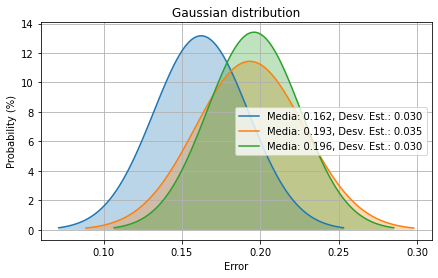

In [30]:
plot_multiple_gaussian_distributions([error_ent, error_linear, error_other])